In [1]:
from pymongo import MongoClient
import pandas as pd 
import numpy as np 
import os 

import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def conn_db(): 

    user = os.getenv("DBUSER", 'signature')
    pwd = os.getenv("DBPWD", 'shanekang')
    ip_addr = os.getenv("DBADDR", '54.180.213.105')

    conn = MongoClient(f'mongodb://{user}:{pwd}@{ip_addr}:27017') 
    return conn

def get_confirmed_data(): 

    conn = conn_db() 
    domestic_cumul_collection = conn.DomesticCOVID.domestic_cumul 
    total_data = [[elem['date'], elem['confirmed']] for elem in domestic_cumul_collection.find({})]
    conn.close() 

    confirmed_df = pd.DataFrame(total_data, columns=['date', 'confirmed'])
    confirmed_df['date'] = pd.to_datetime(confirmed_df['date'])
    
    return confirmed_df

confirmed_df = get_confirmed_data() 
confirmed_df

,date,confirmed
0,2020-01-21,1
1,2020-01-22,1
2,2020-01-23,1
3,2020-01-24,2
4,2020-01-25,2
...,...,...
298,2020-11-14,28338
299,2020-11-15,28546
300,2020-11-16,28769
301,2020-11-17,28998


In [3]:
data = confirmed_df['confirmed'].to_numpy()

In [4]:
def to_confirmed_day(data): 
    diff = [data[0]]
    for i in range(1, len(data)): 
        diff.append(data[i]-data[i-1])
    return np.array(diff)
data = to_confirmed_day(data)
data[:5]

array([1, 0, 0, 1, 0], dtype=int64)

In [5]:
from sklearn.preprocessing import StandardScaler

sdsc = StandardScaler() 
scaled_data = sdsc.fit_transform(data[:, None]) 
scaled_data[:5]

array([[-0.81216147],
       [-0.82064482],
       [-0.82064482],
       [-0.81216147],
       [-0.82064482]])

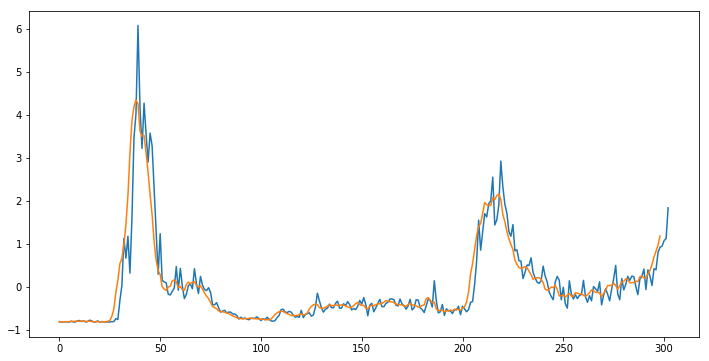

In [45]:
# def moving_average(a, n=3):
#     ret = np.cumsum(a, dtype=float)
#     ret[n:] = ret[n:] - ret[:-n]
#     return ret[n-1:] / n

# plt.figure(figsize=(12,6))
# plt.plot(scaled_data)
# plt.plot(moving_average(scaled_data, n=5))

In [6]:
def create_dataset(data, test_size, look_back): 

    train = scaled_data[:-test_size]
    test = scaled_data[-test_size-look_back:]
    
    X_train, y_train = list(), list()
    X_test, y_test = list(), list() 
    
    for i in range(len(train)-look_back):
        X_train.append(train[i:i+look_back, 0])
        y_train.append(train[i + look_back, 0])
    
    for i in range(len(test)-look_back): 
        X_test.append(test[i:i+look_back, 0])
        y_test.append(test[i + look_back, 0])
        
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

def plot_predict(models, X_test, y_test): 
    
    test_df = pd.DataFrame(X_test) 
    preiods = len(test_df)

    test_df = test_df.loc[:0]
    columns = test_df.columns
    
    model_names = [models[i].__class__.__name__ for i in range(3)] 
    results = {name: [] for name in model_names}

    for i in range(preiods):
        for model, name in zip(models, model_names): 
            predictions = predict_model(model, data=test_df)
            results[name].append(predictions['Label'][0]) 
            test_df = pd.DataFrame([predictions.iloc[0][1:].to_list()], 
                                    columns=columns)
    plt.plot(y_test)
    for pred in results.values(): plt.plot(pred)
    plt.legend(['real'] + [name for name in results.keys()])
    
    plt.show()

In [7]:
X_train, X_test, y_train, y_test = create_dataset(scaled_data, 7, look_back=3) 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((293, 3), (293,), (7, 3), (7,))

In [8]:
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train
train_df.head()

,0,1,2,target
0,-0.812161,-0.820645,-0.820645,-0.812161
1,-0.820645,-0.820645,-0.812161,-0.820645
2,-0.820645,-0.812161,-0.820645,-0.820645
3,-0.812161,-0.820645,-0.820645,-0.803678
4,-0.820645,-0.820645,-0.803678,-0.820645


In [9]:
from pycaret.regression import *

In [10]:
exp_reg1 = setup(data = train_df, target = 'target', session_id=1) 

,Description,Value
0,session_id,1
1,Target,target
2,Original Data,"(293, 4)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(205, 3)"


In [11]:
top3 = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.2086,0.1438,0.3396,0.7828,0.1565,1.8912,1.0440
ridge,Ridge Regression,0.2238,0.1377,0.3449,0.7748,0.1622,2.0264,1.1110
br,Bayesian Ridge,0.2247,0.1384,0.3460,0.7740,0.1629,2.0377,1.1230
lr,Linear Regression,0.2251,0.1384,0.3465,0.7736,0.1633,2.0454,0.8590
lar,Least Angle Regression,0.2251,0.1384,0.3465,0.7736,0.1633,2.0454,1.0870
knn,K Neighbors Regressor,0.2168,0.1625,0.3522,0.7622,0.1599,1.9034,1.0510
et,Extra Trees Regressor,0.2301,0.1511,0.3561,0.7551,0.1623,1.8434,1.3360
rf,Random Forest Regressor,0.2274,0.1418,0.3559,0.7497,0.1591,1.6422,1.3210
omp,Orthogonal Matching Pursuit,0.2221,0.1405,0.3516,0.7487,0.1620,1.9629,1.1930
gbr,Gradient Boosting Regressor,0.2301,0.1492,0.3671,0.7416,0.1631,1.6078,1.4810


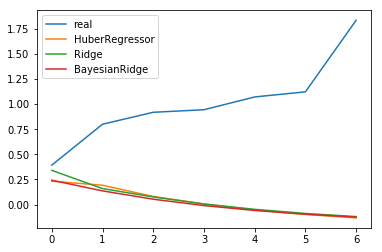

In [12]:
plot_predict(top3, X_test, y_test) 

---

In [13]:
X_train, X_test, y_train, y_test = create_dataset(scaled_data, 7, look_back=5)
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train

exp_reg2 = setup(data = train_df, target = 'target', session_id=2) 

,Description,Value
0,session_id,2
1,Target,target
2,Original Data,"(291, 6)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(203, 5)"


In [14]:
top3 = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.2314,0.1597,0.3786,0.8095,0.1690,2.2818,1.0310
catboost,CatBoost Regressor,0.2320,0.1917,0.3999,0.7960,0.1816,1.3453,1.9680
ridge,Ridge Regression,0.2465,0.1811,0.4009,0.7897,0.1744,2.5639,1.0620
br,Bayesian Ridge,0.2473,0.1818,0.4022,0.7876,0.1740,2.5931,1.0380
lr,Linear Regression,0.2477,0.1813,0.4024,0.7866,0.1733,2.6258,0.9300
lar,Least Angle Regression,0.2477,0.1813,0.4024,0.7866,0.1733,2.6258,1.1120
huber,Huber Regressor,0.2410,0.2041,0.4151,0.7849,0.1792,2.3110,1.0020
et,Extra Trees Regressor,0.2397,0.1949,0.4070,0.7617,0.1815,1.5712,1.1400
knn,K Neighbors Regressor,0.2393,0.2273,0.4285,0.7515,0.1865,1.3368,1.0480
rf,Random Forest Regressor,0.2446,0.1925,0.4108,0.7398,0.1816,1.7131,1.1720


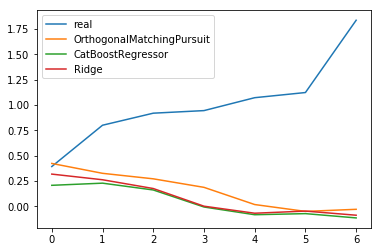

In [15]:
plot_predict(top3, X_test, y_test) 

---

In [16]:
X_train, X_test, y_train, y_test = create_dataset(scaled_data, 7, look_back=7)
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train

exp_reg3 = setup(data = train_df, target = 'target', session_id=3) 

,Description,Value
0,session_id,3
1,Target,target
2,Original Data,"(289, 8)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(202, 7)"


In [17]:
top3 = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.2109,0.1477,0.3428,0.8468,0.1536,2.0283,1.0100
et,Extra Trees Regressor,0.2158,0.1651,0.3515,0.8286,0.1589,1.4923,1.1180
huber,Huber Regressor,0.2226,0.1841,0.3697,0.8284,0.1611,1.9373,1.0000
rf,Random Forest Regressor,0.2128,0.1563,0.3513,0.8186,0.1618,1.6233,1.1610
ridge,Ridge Regression,0.2279,0.1950,0.3845,0.8150,0.1624,1.8920,1.0030
br,Bayesian Ridge,0.2285,0.1970,0.3861,0.8135,0.1628,1.8988,1.0260
lr,Linear Regression,0.2323,0.2021,0.3925,0.8073,0.1649,1.9139,0.9790
lar,Least Angle Regression,0.2323,0.2021,0.3925,0.8073,0.1649,1.9139,1.0370
catboost,CatBoost Regressor,0.2206,0.1626,0.3589,0.8065,0.1607,1.7094,2.3160
ada,AdaBoost Regressor,0.2448,0.1567,0.3620,0.7952,0.1744,1.3862,0.9930


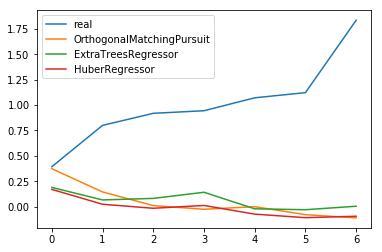

In [18]:
plot_predict(top3, X_test, y_test) 

---

In [19]:
X_train, X_test, y_train, y_test = create_dataset(scaled_data, 7, look_back=9)
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train

exp_reg4 = setup(data = train_df, target = 'target', session_id=4) 

,Description,Value
0,session_id,4
1,Target,target
2,Original Data,"(287, 10)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(200, 9)"


In [20]:
top3 = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.2497,0.1700,0.3823,0.8288,0.1713,1.5169,1.0010
et,Extra Trees Regressor,0.2511,0.2075,0.4177,0.7905,0.1836,0.8391,1.3160
huber,Huber Regressor,0.2444,0.2117,0.4244,0.7883,0.1756,1.2247,1.1060
catboost,CatBoost Regressor,0.2592,0.2387,0.4348,0.7804,0.1826,1.2610,2.3630
rf,Random Forest Regressor,0.2522,0.2193,0.4333,0.7794,0.1877,0.8471,1.2780
knn,K Neighbors Regressor,0.2512,0.2340,0.4277,0.7785,0.1710,0.8715,1.0920
br,Bayesian Ridge,0.2672,0.2341,0.4449,0.7729,0.1846,1.5480,1.0090
ridge,Ridge Regression,0.2673,0.2342,0.4455,0.7724,0.1850,1.5564,1.0560
lar,Least Angle Regression,0.2693,0.2434,0.4539,0.7628,0.1872,1.5777,0.9980
lr,Linear Regression,0.2693,0.2434,0.4539,0.7628,0.1872,1.5777,1.0130


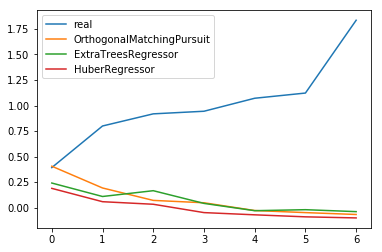

In [21]:
plot_predict(top3, X_test, y_test) 

---

In [22]:
X_train, X_test, y_train, y_test = create_dataset(scaled_data, 7, look_back=11)
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train

exp_reg5 = setup(data = train_df, target = 'target', session_id=5) 

,Description,Value
0,session_id,5
1,Target,target
2,Original Data,"(285, 12)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(199, 11)"


In [23]:
top3 = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.2161,0.1285,0.3416,0.8541,0.1521,1.8656,1.0350
et,Extra Trees Regressor,0.2222,0.1407,0.3561,0.8467,0.1632,1.8219,1.1760
rf,Random Forest Regressor,0.2162,0.1306,0.3475,0.8456,0.1631,1.8412,1.2330
ada,AdaBoost Regressor,0.2488,0.1382,0.3558,0.8400,0.1763,1.5722,0.9990
catboost,CatBoost Regressor,0.2213,0.1480,0.3604,0.8379,0.1604,1.7170,2.4190
gbr,Gradient Boosting Regressor,0.2285,0.1432,0.3628,0.8361,0.1620,2.2249,1.0140
huber,Huber Regressor,0.2239,0.1575,0.3803,0.8288,0.1616,2.2064,1.0810
xgboost,Extreme Gradient Boosting,0.2393,0.1626,0.3777,0.8264,0.1665,2.3640,1.5000
br,Bayesian Ridge,0.2399,0.1774,0.4032,0.8012,0.1643,1.8348,1.0630
ridge,Ridge Regression,0.2402,0.1777,0.4034,0.8003,0.1648,1.8467,1.1330


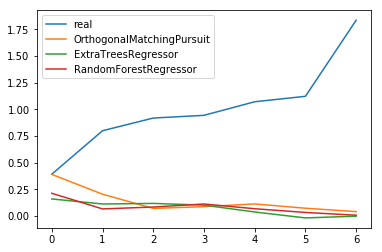

In [24]:
plot_predict(top3, X_test, y_test) 

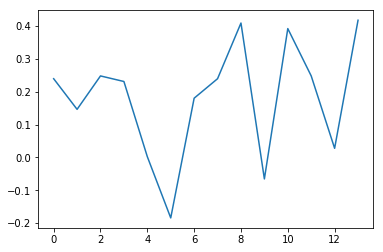

In [26]:
plt.plot(y_train[-14:])

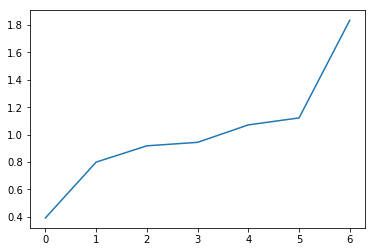

In [29]:
plt.plot(y_test)

In [32]:
def plot_predict(models, X_test, y_test, preiods): 
    
    test_df = pd.DataFrame(X_test) 
#     preiods = len(test_df)

    test_df = test_df.loc[:0]
    columns = test_df.columns
    
    model_names = [models[i].__class__.__name__ for i in range(3)] 
    results = {name: [] for name in model_names}

    for i in range(preiods):
        for model, name in zip(models, model_names): 
            predictions = predict_model(model, data=test_df)
            results[name].append(predictions['Label'][0]) 
            test_df = pd.DataFrame([predictions.iloc[0][1:].to_list()], 
                                    columns=columns)
#     plt.plot(y_test)
    for pred in results.values(): plt.plot(pred)
    plt.legend(['real'] + [name for name in results.keys()])
    
    plt.show()

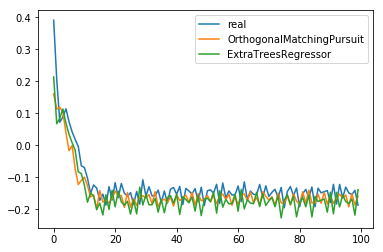

In [33]:
plot_predict(top3, X_test, y_test, 100) 